##Libraries :

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Load your dataset
df = pd.read_csv('/content/drive/My Drive/sys_intel/data.csv')

##  One-hot encode 'Network_Type' (drop first category GSM)
df_encoded = pd.get_dummies(df, columns=['Network_Type'], drop_first=True)

# Label encode 'Network_Type'
network_encoder = LabelEncoder()
df['Network_Type_Encoded'] = network_encoder.fit_transform(df['Network_Type'])
# GSM -> 0, 4G -> 1, 5G -> 2 (check with network_encoder.classes_)

# Features and target
feature_cols = [
    'RSRP_dBm', 'RSRQ_dB', 'SINR_dB', 'RSSI_dBm', 'Data_Throughput_Mbps',
    'Latitude', 'Longitude', 'Network_Type_Encoded'
]
X = df[feature_cols]
y = df['Signal_Quality']


In [37]:
df

,Timestamp,Latitude,Longitude,Network_Type,RSRP_dBm,RSRQ_dB,SINR_dB,RSSI_dBm,Data_Throughput_Mbps,Signal_Quality,Network_Type_Encoded
0,2025-01-01 23:16:50,34.787271,10.296514,4G,-101.272994,-16.852740,0.468227,-66.364850,30.032922,Poor,0
1,2025-01-01 04:03:12,34.946871,9.344773,5G,-72.464285,-10.787684,-0.120848,-60.165930,73.586586,Poor,1
2,2025-01-01 00:54:38,35.709095,10.744789,5G,-83.400303,-5.159921,26.250183,-87.476605,100.000000,Excellent,1
3,2025-01-01 10:00:48,34.680009,10.226232,GSM,-90.067076,-7.552177,-0.018152,-68.756295,6.493923,Poor,2
4,2025-01-01 08:54:58,35.739299,9.314408,GSM,-112.199068,-6.288460,0.877989,-71.412701,5.521745,Poor,2
...,...,...,...,...,...,...,...,...,...,...,...
995,2025-01-01 01:58:24,35.368871,10.159474,5G,-115.420896,-8.831762,24.611830,-77.894648,89.207297,Poor,1
996,2025-01-01 06:49:46,35.006441,10.334074,GSM,-74.134321,-3.737551,-3.709072,-83.279941,6.736923,Poor,2
997,2025-01-01 18:52:32,35.530298,10.823154,4G,-113.159068,-18.827714,2.391514,-80.271384,28.503869,Poor,0
998,2025-01-01 13:10:19,34.970581,9.691240,5G,-72.488132,-19.030070,1.601821,-73.502971,76.158666,Poor,1


In [38]:
# Encode target
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

              precision    recall  f1-score   support

   Excellent       1.00      0.95      0.98        44
        Fair       0.97      0.97      0.97        59
        Good       0.94      0.96      0.95        53
        Poor       0.99      1.00      1.00       144

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.98      0.98      0.98       300



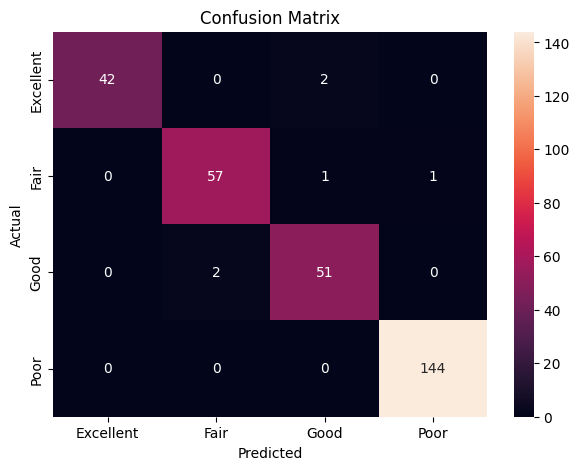

In [39]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

# Confusion matrix plot
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
# Save model and encoders to disk
joblib.dump(model, '/content/drive/My Drive/sys_intel/rf_model.joblib')
joblib.dump(network_encoder, '/content/drive/My Drive/sys_intel/network_encoder.joblib')
joblib.dump(target_encoder, '/content/drive/My Drive/sys_intel/target_encoder.joblib')
joblib.dump(scaler, '/content/drive/My Drive/sys_intel/scaler.joblib')

print("Model, encoders, and scaler saved successfully.")


Model, encoders, and scaler saved successfully.


In [45]:
# Load saved objects
model = joblib.load('/content/drive/My Drive/sys_intel/rf_model.joblib')
network_encoder = joblib.load('/content/drive/My Drive/sys_intel/network_encoder.joblib')
target_encoder = joblib.load('/content/drive/My Drive/sys_intel/target_encoder.joblib')
scaler = joblib.load('/content/drive/My Drive/sys_intel/scaler.joblib')
# Predict on new input
new_input = {
    'RSRP_dBm': -85,
    'RSRQ_dB': -10,
    'SINR_dB': 1,
    'RSSI_dBm': -65,
    'Data_Throughput_Mbps': 1,
    'Latitude': 35.7,
    'Longitude': 10.5,
    'Network_Type': 'GSM'
}

# Encode Network_Type for new input
new_input['Network_Type_Encoded'] = network_encoder.transform([new_input.pop('Network_Type')])[0]

# Convert to DataFrame and scale
new_input_df = pd.DataFrame([new_input])
new_input_scaled = scaler.transform(new_input_df)

# Predict and decode label
pred_encoded = model.predict(new_input_scaled)
pred_label = target_encoder.inverse_transform(pred_encoded)
print(f"\nPredicted Signal Quality: {pred_label[0]}")


Predicted Signal Quality: Poor
